# Aula de Demonstração Prática II

In [0]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

## Resumo dos Dados

O conjunto de dados usado neste notebook é o MNIST, um conjunto de imagens de digitos manuscritos. O dataset contém 60000 imagens de treino e 10000 imagens de teste, cada uma de tamanho 28x28 pixeis. Cada imagem possui um target associado, que é o número do digito na imagem (entre 0 e 9). Este dataset também é disponibilizado no próprio Keras.

Fonte: http://yann.lecun.com/exdb/mnist/

In [0]:
# Carrega as imagens ja separadas entre treino e teste. Na primeira vez eh necessario fazer o download
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# Pega o tamanho das imagens e adiciona uma dimensão a mais
# (essa dimensão é usada para o canal do cor, porém neste caso
# são imagens em escala de cinza, portanto a dimensão é de tamanho 1)
img_shape = x_train.shape[1:] + (1, )

### Exemplos de imagens

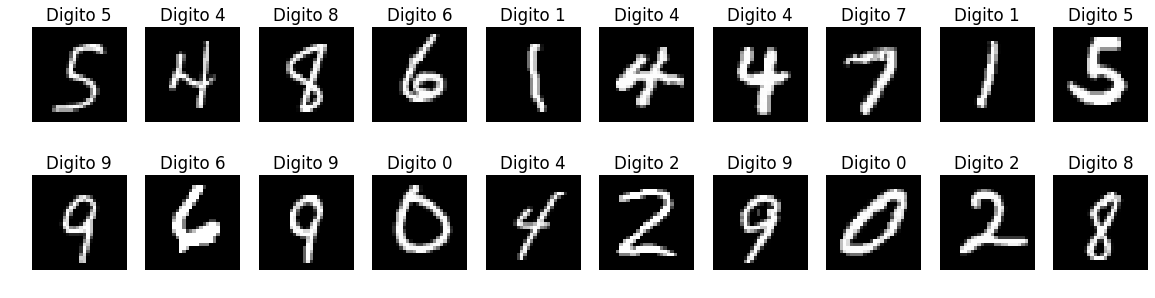

In [0]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Digito {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

## Preprocessamento

In [0]:
# Normaliza a intensidade dos pixels para o intervalo [0, 1]
x_train = x_train/255
x_test = x_test/255

# Adiciona uma dimensão a mais
x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)


# Amostra os dados caso necessario
# np.random.seed(1)

# idx = list(range(x_train.shape[0]))
# np.random.shuffle(idx)
# idx = idx[:10000]
# x_train = x_train[idx]
# y_train = y_train[idx]

# idx = list(range(x_test.shape[0]))
# np.random.shuffle(idx)
# idx = idx[:2000]
# x_test = x_test[idx]
# y_test = y_test[idx]


# One-hot encoding dos targets
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

# Pega o número de classes
n_classes = y_train.shape[1]

## Modelo

In [0]:
# Cria o modelo do Keras usando a API funcional
model_input = layers.Input(shape=img_shape, name="Input")

# Parte de extração de features: convolução e pooling
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1")(model_input)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), name="Pool1")(x)

# Camada que "achata" para depois usar em camadas fully connected
x = layers.Flatten(name="Flatten")(x)

# Camada fully connected (aqui chamada de Dense)
x = layers.Dense(128, activation="relu", name="Dense1")(x)

# Dropout com a probabilide de remover cada neuronio
x = layers.Dropout(0.5, name="Dropout")(x)

# Ultima camada com ativacao softmax, que tem como saida 
# uma probabilidade para cada classe
model_output = layers.Dense(n_classes, activation='softmax', name="Output")(x)

model = models.Model(model_input, model_output)


## Como ficaria a mesma rede usando a forma sequencial
# model = models.Sequential()
# model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", 
#                  padding="same", name="Conv1", input_shape=img_shape))
# model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", 
#                  padding="same", name="Conv2"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))
# model.add(layers.Flatten(name="Flatten"))
# model.add(layers.Dense(128, activation="relu", name="Dense1"))
# model.add(layers.Dropout(0.4, name="Dropout"))
# model.add(layers.Dense(n_classes, activation='softmax', name="Output"))

# Resumo do modelo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
Conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 14, 14, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 128)               1605760   
_________________________________________________________________
Dropout (Dropout)            (None, 128)               0         
__________

In [0]:
# Inicializa o otimizados. Adam é uma variação do SGD
optimizer = optimizers.Adam(lr=0.01)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Treina por 10 epocas com mini-batches de 32 exemplos.
# A API aceita tambem dados de validacao, que sao usadas ao final 
# de cada epoca para medir a metrica principal
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.2434 - acc: 0.9267 - val_loss: 0.0752 - val_acc: 0.9765
Epoch 2/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.1166 - acc: 0.9654 - val_loss: 0.0586 - val_acc: 0.9816
Epoch 3/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.0987 - acc: 0.9708 - val_loss: 0.0444 - val_acc: 0.9860
Epoch 4/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.0930 - acc: 0.9724 - val_loss: 0.0508 - val_acc: 0.9844
Epoch 5/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.0858 - acc: 0.9748 - val_loss: 0.0482 - val_acc: 0.9866
Epoch 6/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.0772 - acc: 0.9768 - val_loss: 0.0437 - val_acc: 0.9873
Epoch 7/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.0735 - acc: 0.9779 - val_loss: 0.0509 - val_acc

## Resultados

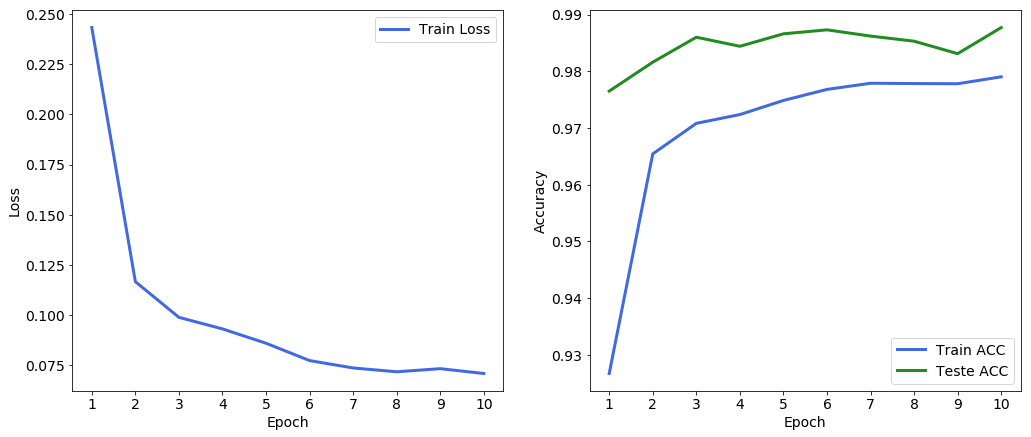

In [0]:
# Gera graficos do resultado do treino
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
        label="Train Loss", color="royalblue", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["acc"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
        label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
        label="Teste ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["acc"])+1))
axes[1].legend()
plt.show()

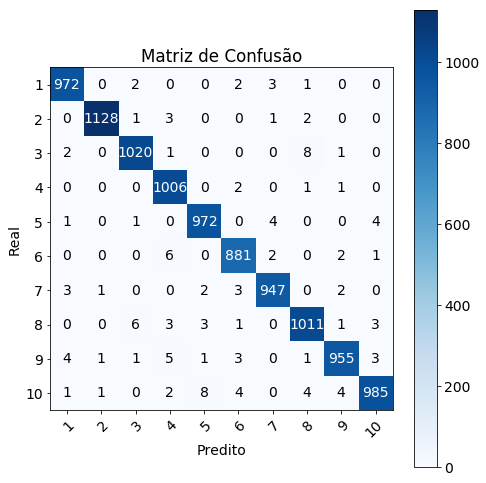

In [0]:
# Matriz de Confusao

# Predições
y_proba = model.predict(x_test)
y_pred = np.argmax(y_proba, axis=1)

# Labels (desfaz o one-hot encode)
y_true = np.argmax(y_test, axis=1)

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(1, 11))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Matriz de Confusão",
       ylabel="Real",
       xlabel="Predito")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

### Exemplos Errados

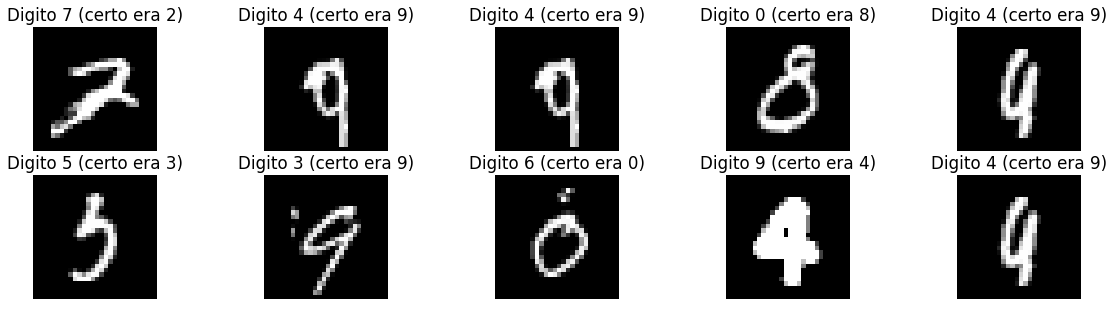

In [0]:
missed = y_pred != y_true

x_missed = x_test[missed]
y_missed = y_pred[missed]
y_true_missed = y_true[missed]

n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_missed.shape[0])
        axes[i][j].imshow(x_missed[img_i, :, :, 0], cmap="gray")
        axes[i][j].set_title("Digito {} (certo era {})".format(y_missed[img_i], y_true_missed[img_i]))
        axes[i][j].axis("off")
plt.show()

## Visualização do Modelo

### Filtros na Primeira Camada

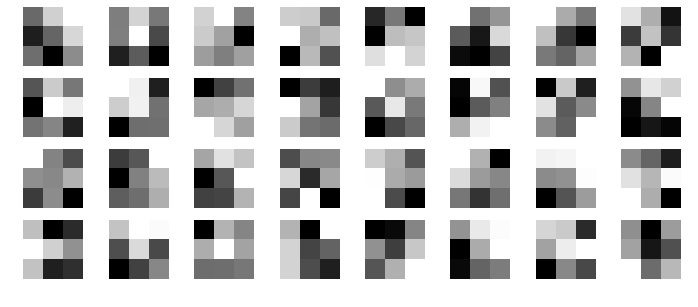

In [0]:
# Pega na camada Conv1 os pesos dos filtros (no indice 0, o indice 1 são os bias)
kernels = model.get_layer("Conv1").get_weights()[0]

n_rows = 4
n_cols = 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))

for k in range(kernels.shape[3]):
    i = k//n_cols
    j = k%n_cols
    axes[i][j].imshow(kernels[:, :, 0, k], cmap="gray")
    axes[i][j].axis("off")
plt.show()

### Representação

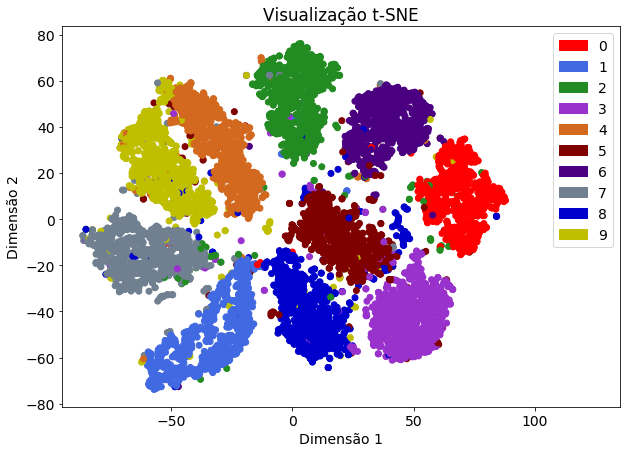

In [0]:
# Pega a camada Flatten
flatten = model.get_layer("Flatten")

# Cria um modelo intermediario cuja saida é a representação do dado na Flatten
int_model = models.Model(model_input, flatten.output)

# Gera a representação nos dados de teste
flatten_out = int_model.predict(x_test)

# Roda o PCA seguido do t-SNE
pca_out = PCA(50).fit_transform(flatten_out)
tsne_out = TSNE().fit_transform(pca_out)

colors = ["red", "royalblue", "forestgreen", "darkorchid", "chocolate", "maroon", "indigo", "slategray", "mediumblue", "y"]

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(tsne_out[:, 0], tsne_out[:, 1], color=[colors[i] for i in y_true])
ax.legend(handles=[mpl.patches.Patch(color=colors[i], label=i) for i in range(10)])
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + x_range*0.2)
plt.title("Visualização t-SNE")
plt.ylabel("Dimensão 2")
plt.xlabel("Dimensão 1")
plt.show()

## Dicas de Consulta
https://keras.io/  
http://cs231n.github.io/  
http://karpathy.github.io/2019/04/25/recipe/